In [91]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from enum import Enum
from typing import NamedTuple
from time import sleep
# Third-Party Library Imports
import numpy as np
from numpy.typing import ArrayLike
import pandas as pd
import xarray as xr
from scipy.stats import spearmanr, mannwhitneyu

# Plotting imports
import hvplot.xarray
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker as mticker
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))

import utils
import plotting_utils
import climate_utils
import stats
import time_of_emrgence_calc as toe
import toe_constants as toe_const

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', message="p-value floored: true value smaller than 0.001")
warnings.filterwarnings('ignore', message="p-value capped: true value larger than 0.25")

In [2]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

In [3]:
# client.close()

In [4]:
from dask.distributed import Client
client = Client(threads_per_worker=1, n_workers=6) #n_workers=2
client

2024-05-25 15:35:15,264 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/116461277.gadi-pbs/dask-worker-space/worker-2brb01nn', purging
2024-05-25 15:35:15,265 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/116461277.gadi-pbs/dask-worker-space/worker-kvu8fwrv', purging
2024-05-25 15:35:15,265 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/116461277.gadi-pbs/dask-worker-space/worker-_9w_34zg', purging
2024-05-25 15:35:15,265 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/116461277.gadi-pbs/dask-worker-space/worker-hew18eu2', purging
2024-05-25 15:35:15,266 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/116461277.gadi-pbs/dask-worker-space/worker-2fsvk_ec', purging
2024-05-25 15:35:15,266 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/116461277.gadi-pbs/dask-worker-space/worker-sk16a2g0', purging
2024-05-25 15:35

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 6
Total threads: 6,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41507,Workers: 6
Dashboard: /proxy/8787/status,Total threads: 6
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:39159,Total threads: 1
Dashboard: /proxy/40085/status,Memory: 41.86 GiB
Nanny: tcp://127.0.0.1:34959,


In [5]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=True)
np.set_printoptions(precision=2, suppress=True, edgeitems=1)

In [6]:
ROOT_DIR = '/g/data/w40/ab2313/PhD/time_of_emergence'
os.listdir(os.path.join(ROOT_DIR, 'best'))

['Complete_TAVG_LatLong1.nc',
 'best_mask_old.zarr',
 'best_mask.zarr',
 'Land_and_Ocean_LatLong1_time_chunk.zarr',
 'Land_and_Ocean_LatLong1.zarr',
 'Land_and_Ocean_LatLong1.nc',
 '.ipynb_checkpoints']

In [7]:
best_ds_raw = xr.open_dataset(os.path.join(ROOT_DIR, 'best', 'Land_and_Ocean_LatLong1_time_chunk.zarr'), 
                    chunks={'time':-1, 'latitude': 90, 'longitude': 120},
                    use_cftime=True)

best_ds_raw['time'] = xr.cftime_range(start='1850-01-01', freq='M', periods=len(best_ds_raw.time.values))
best_ds = best_ds_raw.copy(deep=True)['temperature']
best_ds = best_ds.resample(time='Y').mean()
best_ds = best_ds.compute()

In [8]:
# Create a data set for the base period used as the pre-industrial climate 
start_end_tuple = (1850, 1900)#(1900, 1931)

base_period_ds = best_ds.where(best_ds.time.dt.year.isin(np.arange(*start_end_tuple)), drop=True)
base_period_ds

<xarray.DataArray 'temperature' (time: 50, lat: 180, lon: 360)>
array([[[  nan, ...,   nan],
        ...,
        [  nan, ...,   nan]],

       ...,

       [[  nan, ...,   nan],
        ...,
        [-0.03, ..., -0.03]]], dtype=float32)
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 1899-12-31 00:00:00
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

In [9]:
# Create a mask that removes any grid celss where there are less than 40 point in the base period
base_period_ds_count = base_period_ds.count(dim='time')
data_availability_mask = xr.where(base_period_ds_count>=40, 1, 0)
data_availability_mask

<xarray.DataArray 'temperature' (lat: 180, lon: 360)>
array([[0, ..., 0],
       ...,
       [0, ..., 0]])
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

In [10]:
# Apply the mask to both the base period and the full dataset
best_ds = best_ds.where(data_availability_mask)
base_period_ds = base_period_ds.where(data_availability_mask)

In [11]:
land_mask_ds = xr.open_dataarray('/g/data/w40/ab2313/PhD/time_of_emergence/best/best_mask.zarr')
land_mask_ds

<xarray.DataArray 'land_mask' (lat: 180, lon: 360)>
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes: (5)

# Detrending with Lowess

In [12]:
client.cluster.scale(18)
sleep(5)

In [13]:
def apply_lowess(arr):
    if all(np.isnan(arr)): return arr

    x = np.arange(arr.shape[0])
    yhat = lowess(arr,x, return_sorted=False)
    return yhat

In [17]:
best_ds = best_ds.chunk({'time':-1, 'lat':10})

In [18]:
lowess_ds = xr.apply_ufunc(
    apply_lowess, 
    best_ds, 
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True, 
    dask='parallelized',
    # output_dtypes=float
    
)


In [19]:
%%time
lowess_ds = lowess_ds.compute()

CPU times: user 6.17 s, sys: 1.18 s, total: 7.35 s
Wall time: 53.6 s


In [28]:
best_detrend_ds = best_ds - lowess_ds

In [33]:
client.cluster.scale(6)
sleep(7)

In [30]:
from scipy.stats import levene

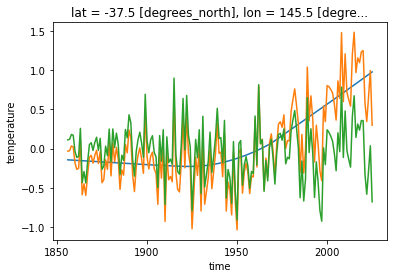

In [29]:
latlon_sel = dict(lat=-38, lon=145, method='nearest')
lowess_ds.sel(**latlon_sel).plot()
best_ds.sel(**latlon_sel).plot()
best_detrend_ds.sel(**latlon_sel).plot()

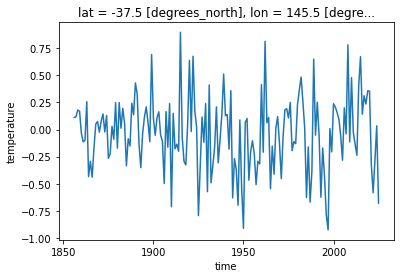

In [35]:
best_detrend_ds.sel(**latlon_sel).plot()

(array([ 2.,  3.,  6.,  3., 13., 10.,  8.,  2.,  1.,  2.]),
 array([-0.93, -0.75, -0.58, -0.4 , -0.23, -0.06,  0.12,  0.29,  0.46,
         0.64,  0.81]),
 <BarContainer object of 10 artists>)

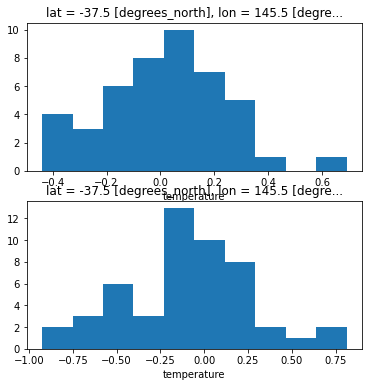

In [46]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))
best_detrend_ds.sel(**latlon_sel).isel(time=slice(0, 50)).plot.hist(ax=ax1)
best_detrend_ds.sel(**latlon_sel).isel(time=slice(100, 150)).plot.hist(ax=ax2)

In [63]:
best_detrend_ds = best_detrend_ds.compute()

In [64]:
arrbase = best_detrend_ds.sel(**latlon_sel).isel(time=slice(0, 50)).dropna(dim='time').values
arr2 = best_detrend_ds.sel(**latlon_sel).isel(time=slice(30, 80)).dropna(dim='time').values

In [65]:
np.std(arrbase), np.std(arr2)

(0.22360870836310662, 0.3283428402605142)

In [77]:
levene(arrbase, arr2).pvalue

0.07297063074280381

In [94]:
mannwhitneyu(arrbase, arr2).pvalue

0.8375820902458722

# Applying Rolling

In [72]:
client.cluster.scale(18)
sleep(7)

In [68]:
window=30

In [69]:
CHUNKS_FOR_PVALUE_TESTS =  {'lat':30, 'lon':30, 'time':-1}

In [95]:
# Creting new datasets that has windown dimnsion for the rolling calculation
best_ds_detrend_window = (best_detrend_ds
                  .chunk(CHUNKS_FOR_PVALUE_TESTS)
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                  .persist()) 

base_period_detrend_window_ds = (best_detrend_ds.where(best_detrend_ds.time == base_period_ds.time, drop=True)
                         .chunk(CHUNKS_FOR_PVALUE_TESTS)
                         .rename({'time':'window_dim'})
                         .persist())

In [98]:
# Creting new datasets that has windown dimnsion for the rolling calculation
best_ds_window = (best_ds
                  .chunk(CHUNKS_FOR_PVALUE_TESTS)
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                  .persist()) 

base_period_detrend_window_ds = (base_period_ds
                         .chunk(CHUNKS_FOR_PVALUE_TESTS)
                         .rename({'time':'window_dim'})
                         .persist())

In [76]:
# The arguements needed for all of the calculations
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

In [84]:
def return_levene_pvalue(arr1, arr2):
    if np.all(np.isnan(arr1)) or np.all(np.isnan(arr2)): return np.nan
    arr1 = arr1[np.isfinite(arr1)]
    arr2 = arr2[np.isfinite(arr2)]
    return levene(arr1, arr2).pvalue

In [118]:
def return_mannwhitney_greater_pvalue(arr1, arr2):
    if np.all(np.isnan(arr1)) or np.all(np.isnan(arr2)): return np.nan
    arr1 = arr1[np.isfinite(arr1)]
    arr2 = arr2[np.isfinite(arr2)]
    return mannwhitneyu(arr1, arr2, alternative='greater').pvalue

In [100]:
def return_mannwhitney_pvalue(arr1, arr2):
    if np.all(np.isnan(arr1)) or np.all(np.isnan(arr2)): return np.nan
    arr1 = arr1[np.isfinite(arr1)]
    arr2 = arr2[np.isfinite(arr2)]
    return mannwhitneyu(arr1, arr2).pvalue

In [85]:
%%time
levene_detrend_ds = xr.apply_ufunc(
        return_levene_pvalue,
        best_ds_detrend_window,
        base_period_detrend_window_ds,
    **rolling_window_kwargs
    ).compute()

CPU times: user 42.1 s, sys: 8.43 s, total: 50.6 s
Wall time: 5min 11s


In [120]:
%%time
mannwhitney_greater_ds = xr.apply_ufunc(
        return_mannwhitney_greater_pvalue,
        best_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

CPU times: user 1min 36s, sys: 18.8 s, total: 1min 55s
Wall time: 12min 16s


In [ ]:
%%time
mannwhitney_ds = xr.apply_ufunc(
        return_mannwhitney_pvalue,
        best_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

In [102]:
%%time
ks_ds = xr.apply_ufunc(
        toe.return_ks_pvalue,
        best_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

CPU times: user 15 s, sys: 2.92 s, total: 17.9 s
Wall time: 1min 45s


In [86]:
levene_detrend_ds

<xarray.DataArray 'temperature' (time: 175, lat: 180, lon: 360)>
array([[[nan, ..., nan],
        ...,
        [nan, ..., nan]],

       ...,

       [[nan, ..., nan],
        ...,
        [nan, ..., nan]]])
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

In [87]:
PVALUE_THESHOLD1 = 0.01

In [103]:
levene_detrend_toe_ds = leven_detrend_toe_ds

In [88]:
levene_detrend_toe_ds = toe.get_permanent_exceedance(levene_detrend_ds, threshold=PVALUE_THESHOLD1,
                                                    comparison_func=np.less)


In [105]:
ks_toe_ds = toe.get_permanent_exceedance(ks_ds, threshold=PVALUE_THESHOLD1,
                                                    comparison_func=np.less)


In [106]:
mannwhitney_toe_ds = toe.get_permanent_exceedance(mannwhitney_ds, threshold=PVALUE_THESHOLD1,
                                                    comparison_func=np.less)


In [122]:
mannwhitney_greater_toe_ds = toe.get_permanent_exceedance(mannwhitney_greater_ds, threshold=PVALUE_THESHOLD1,
                                                    comparison_func=np.less)


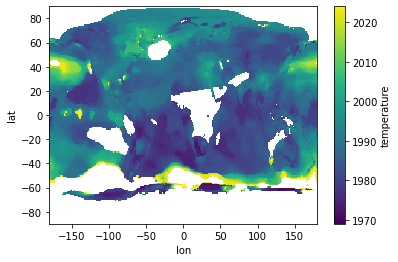

In [123]:
mannwhitney_greater_toe_ds.plot()

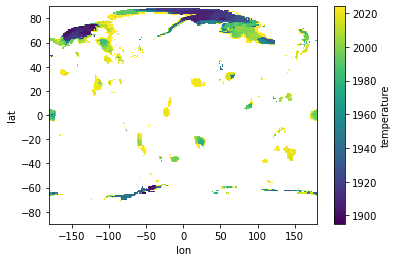

In [110]:
levene_detrend_toe_ds.plot()

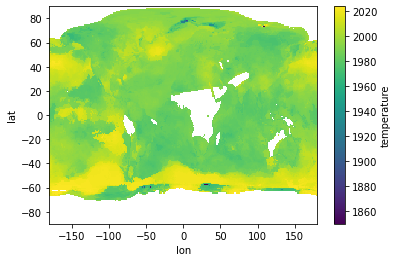

In [109]:
ks_toe_ds.plot()

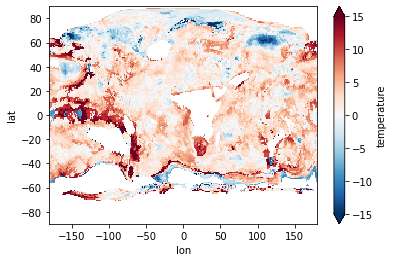

In [127]:
(ks_toe_ds-mannwhitney_greater_toe_ds).plot(robust=True)

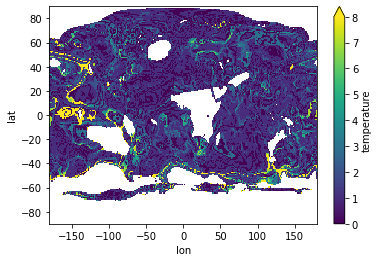

In [126]:
(mannwhitney_toe_ds-mannwhitney_greater_toe_ds).plot(robust=True)

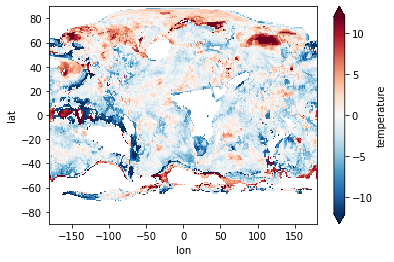

In [125]:
(mannwhitney_toe_ds-ks_toe_ds).plot(robust=True)

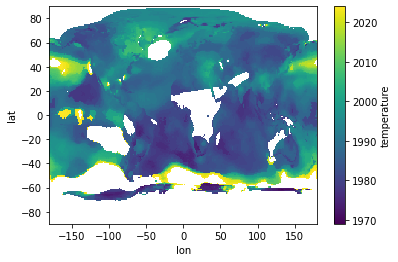

In [108]:
mannwhitney_toe_ds.plot()

(array([    5.,     0.,     1.,     0.,    16.,     3.,   131., 19470.,
        16354.,  8595.]),
 array([1850. , 1867.4, 1884.8, 1902.2, 1919.6, 1937. , 1954.4, 1971.8,
        1989.2, 2006.6, 2024. ]),
 <BarContainer object of 10 artists>)

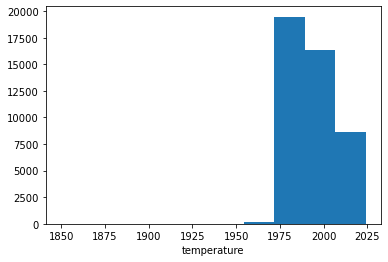

In [114]:
ks_toe_ds.where(np.isnan(levene_detrend_toe_ds)).plot.hist()

(array([   4.,    1.,    1.,    2.,   14.,    0.,  123., 2962., 2292.,
         253.]),
 array([1850. , 1867.4, 1884.8, 1902.2, 1919.6, 1937. , 1954.4, 1971.8,
        1989.2, 2006.6, 2024. ]),
 <BarContainer object of 10 artists>)

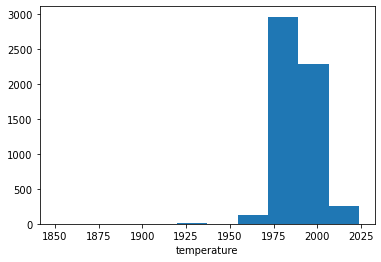

In [113]:
ks_toe_ds.where(np.isfinite(levene_detrend_toe_ds)).plot.hist()